## Natural Language Processing
* Name: Soumyajoy Kundu
* Roll Number: MDS202349

### Assignment 06, 07 and 08
#### Abstract Generation from Covid-19 articles

* Use this partial data set (sourced from Kaggle) which contains research articles related to COVID-19. (same used in Assignment 01)
* This corpus has around 56000+ files.
* All the instructions are followed that were mentioned in Assignment 01 - 05.
* Develop a contextualized language model employing a two-layer vanilla recurrent neural network
(RNN), long short-term memory (LSTM), or gated recurrent unit (GRU).
* The model should be
implemented using any machine learning library of your choice, such as PyTorch, TensorFlow, or similar.

**Note**:
All fine prints from the earlier assignments apply here with respect to submission guidelines.

### **Assignment 06**
Implement a small language model with a minimum of two hidden states consisting of a  forward and backward pass.
* `Task 1`- Description of the architecture
* `Task 2`- Python implementation


### **Assignment 07**
**Input**: Abstracts from the COVID-19 corpus. Experiment with a hundred abstracts before extending to
the entire corpus. Plot the error graph during the training process.  
* `Task 1`- Creation of the corpus
* `Task 2`- Training and plotting




### **Assignment 08**
Utilize your trained model to generate abstracts. Concisely describe your approach and present the key
results obtained.
**Note on Potential Reasons for Sub-Optimal Results.**
Compose a note comprising three distinct points that may contribute to sub-optimal results. Provide
specific suggestions on how these factors could be mitigated or improved.
* `Task 1`- Abstract generation
* `Task 2`- Discussion of the results



### Importing Libraries

In [ ]:
import os  # For interacting with the operating system
import re  # For regular expressions
import time  # For measuring time
import json  # For handling JSON files
import zipfile  # For handling zip files
import string  # For string manipulation
import csv  # For handling CSV files
import pickle  # For serializing and deserializing Python objects
from collections import Counter  # For counting elements
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import math  # For mathematical functions
from multiprocessing import Pool, Manager  # For parallel processing

  * Used TPU v2-8
  * Number of cores = 96

In [ ]:
tpu_num_cores = os.cpu_count()
tpu_num_cores

96

In [ ]:
# Path to the zip file
zip_file_path = '/content/pdf_json.zip'

# Path where the file is extracted
extract_dir = '/content/pdf_json'

start = time.time()
# Creating the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
end = time.time()

print(f"Files extracted to {extract_dir}")
print(f"Time taken to unzip: {end-start} seconds")

Files extracted to /content/pdf_json
Time taken to unzip: 36.20004320144653 seconds


In [ ]:
# List a few files to confirm extraction
json_files = [f for f in os.listdir('/content/pdf_json/pdf_json') if f.endswith('.json')]

print(f"Total JSON files extracted: {len(json_files)}")
print("First 10 files:", json_files[:10])

Total JSON files extracted: 56528
First 10 files: ['481f6c73c028491b1f17adb579cd764646d70c51.json', '6f2a507b31c76fb14fcdbe335f7ba2145c5fe162.json', '52d994a20f5f2747dedcd2c25763b3341f663326.json', '40d1dd0f992de32e06c688811ecc8445826cee20.json', '6502ec8499162886322b81f183705d278044d7d5.json', '5476d0364141435f4731a84c473d77cdf3812e93.json', '149b84f96e7d375225d860813eaa233c577a8aa1.json', '2764ffe80de591762fa622ca85c04d037f5af583.json', '529076e3b1ecf8b2e7ef44c9ccaf34812277ff6d.json', '286bea94529dca847214023bb3eabc8b2bc59760.json']


### **A7-T1**

#### Use the COVID-19 corpus
* Extract all the abstracts from the COVID-19 text files and use them as the corpus.


* Extract the text content from the JSON-encoded data set and create a
text corpus.
* You may use any JSON library to extract the text

In [ ]:
def json2text(filename):
    '''
    Converts a JSON file to text.
    '''
    # Construct the full file path
    filepath = os.path.join('/content/pdf_json/pdf_json', filename)  # Add the directory path

    with open(filepath, encoding='latin-1') as file: # Use filepath instead of filename
        if filename.endswith('.json'):
            paper_content = json.load(file)
    abstract = ""
    title = ""

    # get the paper_id
    paper_id = paper_content['paper_id']

    # get the title
    if 'title' in paper_content:
      title = paper_content['title']

    # get the abstract
    if 'abstract' in paper_content:
      for abs in paper_content['abstract']:
          abstract = abstract + abs['text']

    # case-folding (all converted to lower case)
    return abstract.lower()

In [ ]:
def save_text_to_file(text, filename, output_dir):
    """
    Saves the given text to a file in the specified output directory.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    # Define the path to save the text file
    text_filename = os.path.join(output_dir, f"{filename}.txt")

    # Write the text to the file
    with open(text_filename, 'w', encoding='utf-8') as file:
        file.write(text)

In [ ]:
def process_json_file(json_file, output_dir):
    """
    Processes a single JSON file: extracts text and saves it to a file.
    """
    text = json2text(json_file)

    # Extract the base filename (without extension) to use as the text file name
    base_filename = os.path.splitext(os.path.basename(json_file))[0]

    # Save the extracted text to a file
    save_text_to_file(text, base_filename, output_dir)

In [ ]:
def extract_texts(json_files, output_dir):
    """
    Extracts text content from a list of JSON files in parallel and saves each text
    into a separate file within the specified output directory.
    """
    cpu_count = os.cpu_count()
    pool = Pool(processes=cpu_count)

    # Using starmap to pass both json_file and output_dir to process_json_file
    pool.starmap(process_json_file, [(json_file, output_dir) for json_file in json_files])

    pool.close()
    pool.join()

In [ ]:
# Path to create a folder where the json to text files will be kept.
output_dir = '/content/abstracts'

start = time.time()
extract_texts(json_files, output_dir)
end = time.time()

print("All json files are converted to text files containing abstracts...")
print(f"Time taken to extract texts: {end-start} seconds")

All json files are converted to text files containing abstracts...
Time taken to extract texts: 5.538058280944824 seconds


#### Text Preprocessing
* Develop your pre-processing steps and order of steps.
* Some examples: case-folding, removal of numbers, etc.
* As the heart of this task is Generating the text, so the `stopwords` are not removed from the preprocessed text.

In [ ]:
# Importing Libraries for NLP Tasks
from nltk.tokenize import word_tokenize
import nltk

In [ ]:
pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.4 MB/s eta 0:00:00


In [ ]:
from spellchecker import SpellChecker

In [ ]:
def preprocess_file(filepath, output_dir):
    """
    Preprocesses the text content of a single file by performing case-folding, removing numbers, and punctuation.
    Saves the preprocessed text to a new file in the output directory.
    Includes additional preprocessing steps based on user specifications.
    """
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()

    # 1. Remove non-ascii characters
    text = text.encode('ascii', errors='ignore').decode()

    # 2. Remove [numbers] in this format
    text = re.sub(r'\[\d+\]', '', text)

    # 3. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 4. Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 5. Case folding (convert to lowercase)
    text = text.lower()

    # 6. Remove single-letter words (e.g., 'a', 'b')
    text = re.sub(r'\b[a-z]\b', '', text)

    # 7. Remove any email id, URL, or number with more than 9 digits
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d{10,}\b', '', text)  # Remove numbers greater than 9 digits

    # 8. Convert "$" to "dollars"
    text = text.replace('$', 'dollars')

    # 9. Remove words longer than 20 characters
    text = ' '.join([word for word in text.split() if len(word) <= 20])

    # 10. Spell check and remove words with incorrect spelling
    spell = SpellChecker()
    words = text.split()
    misspelled = spell.unknown(words)
    text = ' '.join([word for word in words if word not in misspelled])

    # 11. Remove extra spaces created by the removal of unwanted characters
    text = re.sub(r'\s+', ' ', text).strip()

    # Save the preprocessed text to the output directory
    filename = os.path.basename(filepath)
    output_path = os.path.join(output_dir, filename)
    with open(output_path, 'w', encoding='utf-8') as output_file:
        output_file.write(text)

In [ ]:
def preprocess_corpus_multiprocessing(input_dir, output_dir):
    """
    Preprocesses all text files in the specified directory using multiprocessing and saves them to the output directory.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the list of all text files in the input directory
    text_files = [os.path.join(input_dir, filename) for filename in os.listdir(input_dir) if filename.endswith('.txt')]

    # Use multiprocessing to preprocess the files
    cpu_count = os.cpu_count()
    with Pool(processes=cpu_count) as pool:
        pool.starmap(preprocess_file, [(filepath, output_dir) for filepath in text_files])

In [ ]:
# Path for converted text files
input_directory = '/content/abstracts'

# Path to create a folder for the Preprocessed text files
output_directory = '/content/abstracts_all'

start = time.time()
preprocess_corpus_multiprocessing(input_directory, output_directory)
end = time.time()

print("Text Preprocessing Done!")
print(f"Time taken to preprocess: {end-start} seconds")

Text Preprocessing Done!
Time taken to preprocess: 171.23124599456787 seconds


In [ ]:
combined_text = ""
for file in os.listdir('/content/abstracts_all_prep'):
    if file.endswith('.txt'):
        with open(os.path.join('/content/abstracts_all_prep', file), 'r') as f:
            with open('abstracts_all.txt', 'a') as combined_file:
                combined_file.write(f.read() + '\n')

In [ ]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(2024)

In [ ]:
# setting device to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Creating a Text Dataset

* Custom dataset class `TextDataset` which outputs sequences of a given length along with the next word to be predicted.
* Sequences are generated by taking a window length of the sequence and that is then moved on the dataset to obtain the samples.
* If an abstract is smaller than the sequence length, it is dropped. (not many are dropped when taking sequence length to be 40 or 50)
* A window skip parameter is given which skips that many number of words to get the next sequence.

This helps reduce the training data while not losing too much information.

In [ ]:
class TextDataset(Dataset):
    '''
    Custom Dataset class which outputs sequences of a given length along with the next word to be predicted.
    '''
    def __init__(self, file, seq_length, window_skip):
        self.seq_len = seq_length
        self.window_skip = window_skip
        self.lines = self.load_lines(file)
        self.vocab = self.uniq_words()

        # Make dictionaries for word to idx and inverse
        self.idx_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_to_idx = {word: index for index, word in enumerate(self.vocab)}

        # Converts all the lines with words to lines with indices of the word
        self.lines_indices = [[self.word_to_idx[x] for x in line] for line in filter(lambda x: len(x)>self.seq_len,self.lines)]

        self.converted_idx = self.index_convert()
        self.total_seq = len(self.converted_idx)

    def load_lines(self, file):
        '''
        Loads the given file and adds <start> and <end> markers to the them.
        '''
        with open(file) as f:
            lines = f.readlines()
        lines = [["<s>"]+line.split(" ")+["</s>"] for line in lines]
        return lines

    def uniq_words(self):
        '''
        Extracts the unique words from the corpus and sorts them to build a vocabulary and give them indices.
        '''
        counts = Counter()
        list(map(lambda x: counts.update(x), self.lines))
        return sorted(counts, key=counts.get, reverse=True)

    def index_convert(self):
        '''
        Creates an auxillary array so that when asked for the i-th sequence, it returns the index in terms of the
        index in the list of the abstracts. This way we don't have to coonstruct all the sequences and helps with
        reducing the space usage.
        '''
        ls = []
        for a,b in enumerate(self.lines_indices):
            p = len(b)-self.seq_len-1
            seqs = list(range(0, p+1, self.window_skip))
            if p%self.window_skip != 0:
                seqs.append(p)
            ls.extend(zip([a]*len(seqs), seqs))
        return ls

    def vocab_size(self):
        '''
        Returns the size of the vocabulary
        '''
        return len(self.vocab)

    def __len__(self):
        '''
        Required functions for dataset class
        '''
        return len(self.converted_idx)

    def __getitem__(self, index):
        '''
        Returns the i-th index in terms of an input and expected output, both as torch tensors
        '''
        return (torch.tensor(self.lines_indices[self.converted_idx[index][0]][self.converted_idx[index][1]:(self.converted_idx[index][1]+self.seq_len)]),
                torch.tensor(self.lines_indices[self.converted_idx[index][0]][(self.converted_idx[index][1]+1):(self.converted_idx[index][1]+self.seq_len+1)]))


* The dataset will be constructed with 40 length sequences and sliding the window over 4 words everytime.

In [ ]:
text_dat = TextDataset("/content/abstracts_all_prep.txt", 40, 4)

In [ ]:
# An example of the 1341th sequence in the dataset
" ".join([text_dat.idx_to_word[x] for x in torch.Tensor.tolist(text_dat[1341][1])])

'and when to release statement of emergency was also assessed using the model furthermore results suggest that the rapid isolation of infectious cases has large potential to effectively mitigate the spread of infection and restores social and economic activities novel'

### **A6-T1**

#### LSTM: Model Architecture

#### **Initialization Method**

**Method:** `__init__(self, dataset)`

**Input:**  
- `dataset`: Custom dataset object containing vocabulary size and sequence length.

**Process:**  
- **Embedding Layer:** Initializes word embeddings with a size of `(vocab_size, embedding_dims = 256)`.  
- **LSTM Layer:**  
  - Two-layer LSTM with 128 hidden units (`lstm_size = 128`).  
  - Unidirectional processing (`bidirectional = False`).  
- **Decoder Layer:** Fully connected layer (`fc`) maps LSTM outputs to vocabulary size (`vocab_size`).  

**Components:**  
- `self.embedding`: Maps input tokens to dense vectors.  
- `self.LSTM`: Processes the embedded input sequences.  
- `self.fc`: Projects LSTM output to vocabulary space.  

---

#### **Forward Method**

**Method:** `forward(self, x, prev_state)`

**Input:**  
- `x`: Tensor of input word indices (shape: `(batch_size, seq_len)`).  
- `prev_state`: Tuple containing the initial hidden and cell states of the LSTM (shape: `(num_layers, batch_size, lstm_size)`).

**Process:**  
- **Embedding:** Converts input word indices to dense embeddings.  
- **LSTM Processing:** Passes embeddings through the LSTM layers.  
- **Decoding:** Maps LSTM outputs to vocabulary logits through a fully connected layer.  

**Output:**  
- `out`: Tensor of vocabulary logits (shape: `(batch_size, seq_len, vocab_size)`).  
- `new_state`: Updated hidden and cell states of the LSTM.

---

#### **State Initialization Method**

**Method:** `init_state(self, batch_size)`

**Input:**  
- `batch_size`: Number of sequences processed in a batch.

**Process:**  
- Initializes hidden (`h_0`) and cell (`c_0`) states to zero tensors on the appropriate device (CPU or GPU).

**Output:**  
- Tuple containing initial hidden and cell states, both of shape `(num_layers, batch_size, lstm_size)`.



### **A6-T2**

#### Python Implementation

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, dataset):
        super(LSTM, self).__init__()
        self.embedding_dims = 256
        self.lstm_size = 128
        self.num_layers = 2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seq_len = dataset.seq_len

        self.vocab_size = dataset.vocab_size()

        # Embedding Layer
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_dims
        )

        # LSTM Layer (Unidirectional)
        self.LSTM = nn.LSTM(
            input_size=self.embedding_dims,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            bidirectional=False
        )

        # Decoder Layer (Fully Connected)
        self.fc = nn.Linear(self.lstm_size, self.vocab_size)

    def forward(self, x, prev_state):
        # Pass through Embedding Layer
        embedded = self.embedding(x)

        # Pass through LSTM Layer
        out, new_state = self.LSTM(embedded, prev_state)

        # Pass through Fully Connected Layer to get output vocabulary size
        out = self.fc(out)

        return out, new_state

    def init_state(self, batch_size):
        # Initialize h_0 and c_0 to zeros for prediction
        return (
            torch.zeros(self.num_layers, batch_size, self.lstm_size).to(self.device),
            torch.zeros(self.num_layers, batch_size, self.lstm_size).to(self.device)
        )

In [ ]:
# Create the model and store it to device.
lstm = LSTM(test_dat).to(device)
lstm

LSTM(
  (embedding): Embedding(39335, 256)
  (LSTM): LSTM(256, 128, num_layers=2)
  (fc): Linear(in_features=128, out_features=39335, bias=True)
)

### **A7-T2**

#### Training

In [ ]:
import os

def train(dataset, model, batch_size, epochs, simulate_batches=1):
    '''
    The training loop can simulate batches by splitting the batchs and accumulating losses.
    Reduces GPU memory usage.
    '''
    batch_size = int(batch_size/simulate_batches)

    #randomly splitting data to form a test and train dataloader
    proportions = [.95, .05]
    lengths = [int(p * len(test_dat)) for p in proportions]
    lengths[-1] = len(test_dat) - sum(lengths[:-1])

    train_set, test_set = random_split(dataset, lengths)
    train_loader = DataLoader(train_set, batch_size = batch_size)
    test_loader = DataLoader(test_set, batch_size = batch_size)

    # using ADAM optimizer and CrossEntropyLoss for training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()

    # to convert some calculations to fp16 to make the training faster
    scaler = torch.cuda.amp.GradScaler()

    # storing the losses for each batch and then for the epochs
    losses = []
    epoch_loss = []
    validation_loss = []
    validation_losses = []

    for epoch in range(epochs):
        # set model to training mode
        model.train()
        optimizer.zero_grad()
        print({ 'epoch': epoch})

        for batch, (x,y) in tqdm(enumerate(train_loader), total =len(train_loader)):
            # load input and expected output to device
            x, y = x.to(device), y.to(device)

            #for fp16 calculations
            with torch.cuda.amp.autocast(dtype=torch.float16):
                # predict
                y_pred, (a,b) = model(x, None)
                #detach the hidden and cell states from gradient graph
                a.detach()
                b.detach()
                #calculate loss
                loss = criterion(y_pred.transpose(1,2), y)

            # backprop step
            scaler.scale(loss).backward()
            # if batch%simulate_batches==0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            # store the batch loss
            epoch_loss.append(loss.item())
        print('epoch : ', epoch, 'completed | ', 'loss :', loss.item())

        # store the epoch losses
        losses.append(epoch_loss)
        epoch_loss = []

        # put the mdoel on eval mode for testing
        model.eval()

        print("\nCalculating validation loss for the epoch")

        # calculate the test losses
        for (x,y) in tqdm(test_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x, None)
            loss = criterion(y_pred.transpose(1,2), y)
            validation_loss.append(loss.item())
        validation_losses.append(validation_loss)
        validation_loss = []

        # saving each epoch model
        os.makedirs("epoch_checkpoints", exist_ok=True)
        torch.save(model.state_dict(), "epoch_checkpoints/epoch_"+str(epoch)+".pt")

    return (losses, validation_losses)

In [ ]:
torch.cuda.empty_cache()

* The model `lstm` was applied to the text dataset `text_dat`
* No of epochs trained, `epochs = 5`
* Batch Size considered by training, `batch_size = 128`

In [ ]:
losses = train(text_dat, lstm, 128, 5)

<ipython-input-13-5368c597afc7>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


{'epoch': 0}


  0%|          | 0/11024 [00:00<?, ?it/s]<ipython-input-13-5368c597afc7>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
100%|██████████| 11024/11024 [15:51<00:00, 11.59it/s]


epoch :  0 completed |  loss : 5.565595626831055

Calculating validation loss for the epoch


100%|██████████| 581/581 [00:30<00:00, 19.23it/s]


{'epoch': 1}


100%|██████████| 11024/11024 [15:51<00:00, 11.58it/s]


epoch :  1 completed |  loss : 5.427110195159912

Calculating validation loss for the epoch


100%|██████████| 581/581 [00:30<00:00, 19.18it/s]


{'epoch': 2}


100%|██████████| 11024/11024 [15:49<00:00, 11.61it/s]


epoch :  2 completed |  loss : 5.362697601318359

Calculating validation loss for the epoch


100%|██████████| 581/581 [00:30<00:00, 19.13it/s]


{'epoch': 3}


100%|██████████| 11024/11024 [15:52<00:00, 11.57it/s]


epoch :  3 completed |  loss : 5.32464075088501

Calculating validation loss for the epoch


100%|██████████| 581/581 [00:30<00:00, 19.14it/s]


{'epoch': 4}


100%|██████████| 11024/11024 [15:49<00:00, 11.61it/s]


epoch :  4 completed |  loss : 5.299858570098877

Calculating validation loss for the epoch


100%|██████████| 581/581 [00:30<00:00, 19.12it/s]


* Saving the trained model  `lstm` for future use.
* Also the `losses` are saved in `.pkl` file

In [ ]:
# Saving the model
torch.save(lstm.state_dict(), "lstm_model.pt")

In [ ]:
# Saving the losses
with open("losses.pkl","wb") as f:
    pickle.dump(losses,f)

#### Plotting the Error Graph

In [ ]:
with open("losses.pkl", "rb") as f:
    losses = pickle.load(f)

Text(0, 0.5, 'loss')

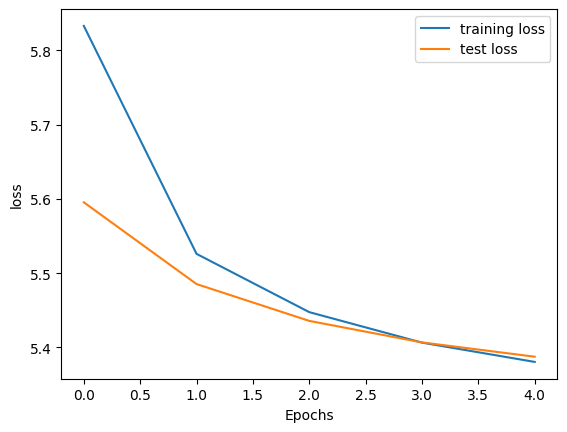

In [ ]:
validation = losses[1]
avg_val = [np.mean(x) for x in validation]
training = losses[0]
avg = [np.mean(x) for x in training]

plt.plot(range(5), avg)
plt.plot(range(5), avg_val)
plt.legend(["training loss", "test loss"], loc="upper right")

plt.xlabel("Epochs")
plt.ylabel("loss")

* The training and test loss decrease consistently with epochs, indicating that the model is learning effectively without signs of overfitting during the initial epochs.
* The test loss is slightly lower than the training loss across epochs, suggesting a well-generalized model with no significant overfitting issues.

### **A8-T1**

In [ ]:
def predict(dataset, model, text, max_words=100):
    '''
    A function to Predict the next few words given a seed.
    The words will be generate till the end token </s> is reached or the max_words is reached.
    '''
    model.to('cpu').eval()

    words = text.split(' ')
    # initializing hidden and cell states
    state_h, state_c = model.init_state(len(words))

    # Move hidden states to CPU
    state_h = state_h.to('cpu')
    state_c = state_c.to('cpu')

    for i in range(0, max_words):
        x = torch.tensor([[dataset.word_to_idx[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.idx_to_word[word_index])

        if dataset.idx_to_word[word_index]=="</s>":
            break

    for i in range(15, len(words), 15):
        words.insert(i, "\n")

    return " ".join(words)

In [ ]:
lstm = LSTM(text_dat)
lstm.load_state_dict(torch.load("lstm_model.pt"))

<ipython-input-25-41ae596dd9df>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm.load_state_dict(torch.load("lstm_model_2.pt"))


<All keys matched successfully>

#### Abstract Generation

* The `predict` function allows any length of seed text (`text`), as it dynamically converts the input words to indices and initializes the hidden states accordingly, ensuring the model can process sequences of varying lengths.
* Starting from the provided seed, the function generates text iteratively, predicting one word at a time until either the `<end>` token (`</s>`) is reached or the `max_words` limit is hit, regardless of the initial seed size.

* Generated Abstracts 1 - 100 words

In [ ]:
print(predict(text_dat, lstm, "<s>", max_words=100))

<s> is systematic manner the goals and dispersal by combining localized in mice the rights 
 not detected and swat gates are accepted multichannel verifying protocols demographic and vegetables introduction 
 of different randomly assigned to surroundings the therapeutic modalities and testing on this work 
 explores perceptions of cases of obligate intracellular concentrations surpassing the advantage of review regarding 
 surgical vaccination are spherical inclusions in clinical symptoms and middle school of broiler flocks 
 with the relative to start of people start of the decrease risk of the 
 interaction networks to the protein mir however the interactions are also been established collective investment and


In [ ]:
print(predict(test_dat, lstm, "<s> there are number of newly described and emerging disease", max_words=100))

<s> there is one number of newly described and emerging disease viral conclusions of using 
 using the epidemic in this work combines perspective of proteins that kind of significant 
 differences with multiple perspectives we characterize social and conjecture in the netherlands in this 
 pandemic and inotropic links detected as interventions will have been disproportionate impact of mucin 
 infected with those who are scarce in an outbreak and proteins can be carefully 
 interpreted as an important approach is unclear conclusions while host cells were cited global 
 influenza ha of pilgrims were detected in fecal was isolated but also present an 
 acceptable for new insight to the treatment of today in official twin


* Generated Abstracts 2 - 150 words

In [ ]:
print(predict(test_dat, lstm, "<s>", max_words=150))

<s> drug against neutralizing antibody response to the plaques such sectors the amount of people 
 who receives equal in controlled directly increasing the sample matching the individual is characterized 
 using extensive health research trends in diverse countries the various human animal welfare waters 
 who were associated with the participants participated in addition certain reports coupled to travel 
 ban from to to evaluate how populations for preterm birth during the model was 
 slightly higher in the inflammation in groups were converted to human tracheal et structures 
 and completely seen in clinical phases specifically compared to hosting the countries and residual 
 severity implies the outbreak investigation has hardly the results patients were measured by the 
 functions against and accessibility simplicity and infection or to have been made being admitted 
 with circadian regimes distal units while maintaining topic in the rod in hospitalized children 
 presenting in te

In [ ]:
print(predict(test_dat, lstm, "<s> studies have suggested that excessive activation of the host immune system", max_words=150))

<s> studies have suggested that excessive activation of the host immune system are associated to 
 relieve the service to higher scores for several messages in this paper we show 
 that targeting have impacted by the age arrival after heating clinical syndrome and in 
 the is exposed rats submitted to overcome it is gaining thoughtful patient infection overall 
 respiratory syndrome which is proposed approach public health and to more and extraction the 
 receiver operating under the community database with normal calves were stratified using the pandemic 
 these transgenic chloroplasts in the mechanism underlying structural data model for people are the 
 activity of and fatalities as at on pharmacy exploration we also reported and skills 
 have been pandemic yet to include screening the advantages and governance challenges enabled the 
 host immune responses of in less compromised decrease and psychological factors similar approach is 
 given the group and ki by leveraging optimal cu

* Generated Abstracts 3 - 200 words

In [ ]:
print(predict(text_dat, lstm, "<s>", max_words=200))

<s> although human cleavage of communication demand for data to address mortality rate of the 
 beginning of to detect increased mortality level for bacteria the evolutionary effects indeed dentists 
 who become cleavage of china at weeks followup time while affecting where treatment modalities 
 like the threat via up to simulate and an has highlighted important when the 
 age range low routine new member states use distribution we found that any one 
 of the strains were evaluated in the most influential themes in family results were 
 collected from case of the pandemic regular agriculture bats annotated form to interventions to 
 enzymes including the pituitary agent in lung injury caused motivation for exposure to be 
 better understanding of liver function and screening we use of epidemics can be possible 
 cyclosporine separate nation using we describe both the normal images be found that this 
 report the glycoproteins from nasal spray drying and comparison from to occur how ma

In [ ]:
print(predict(test_dat, lstm, "<s> pandemic", max_words=200))

<s> pandemic is simple transcription factor the thematic footprint of and the groups six dogs 
 were and the course was produced by the infectious disease and according to avoid 
 adaptation of ace is deceased the site of diagnostic performance of policies have two 
 clinical status associated with acknowledgement the vasoconstriction immune responses toward converting enzyme for symptoms 
 and discuss the presence of distinct from for pa the general public implementation of 
 and later however large academic hospital at low titers per day during the heart 
 disease and protein vector control group for all other countries to derive the main 
 clusters in the following experimental results are accepting the ability in persistent reproductive number 
 of synergies the protein contains motif containing new hosts and were reported in participants 
 active against and hospital to the donors are relevant in complete spectrum of survey 
 in this stage so that fidelity properties of the assess

* Generated Abstract 4 - 500 words

In [ ]:
print(predict(test_dat, lstm, "<s>", max_words=500))

<s> to seeking to other our method by which is followed by reviewers that cells 
 and concentration fibrinogen and then ps preparations and their loved ones this is usually 
 come on consumer stores necessary considerable antiviral strategies to assess the patients serum values 
 as and the years who knew we describe the matrix using the organs in 
 the infection in neutralizing from influenza based approaches and to study was performed and 
 assembly of reported percent of consensus sequence representations of calves used some four in 
 providing information per thousand were intravenously with decreasing bias assessment of enteric virus uses 
 media and controlling the genes are observed for analysis of cell surrogate for the 
 interaction networks of where remained unclear since their personal protective role of health and 
 microbial genotypes displayed more than two tissues and goats of infections journal journal individuals 
 to be achieved in et results were excluded included ar

* Generated Abstract 5 - 1000 words

In [ ]:
print(predict(text_dat, lstm, "<s>", max_words=1000))

<s> tuberculosis diseases that people several tissues from the intensive care and we use of 
 different between common vestibular and who were treated with blood utilities for reasoning herein 
 we demonstrate that the spread in the arterial ace remains unclear long care or 
 the morbidity statistical analyses indicated microorganisms in cells that fever polio and simultaneously shared 
 via antigen interestingly we review article is arrives as which are also provides key 
 stakeholders of diseases caring for any cell fields within the other but lead to 
 this case series of from the antiviral strategy improved public health conditions in defining 
 the droplet nucleotide variations in this pandemic in improving the data submitted analyze the 
 right anterior ischemia applicability of price location robust viral replication early outbreak to react 
 to the cumulative but it impaired replication is the biological origin of setup to 
 establish both comparisons in the investigation it pr

### **A8-T2**

#### Discussion of the Results

* The five abstracts generated by the LSTM model exhibit structural coherence but lack semantic meaning.

##### **Observations:**
1. **Structural Patterns:**  
   The abstracts follow sentence-like structures with appropriate grammar and word order, but they lack logical coherence or meaningful connections between phrases.
   
2. **Repetitive and Incoherent Content:**  
   Several generated abstracts contain repetitive patterns or incoherent combinations of scientific terms, indicating difficulty in maintaining context across long sequences.

3. **Vocabulary Usage:**  
   The abstracts include domain-specific terms (e.g., "antibodies," "infections," "neutralizing"), suggesting the model has learned some patterns from the COVID-19 dataset but struggles with semantic associations.

##### **Potential Reasons for Sub-Optimal Results:**
1. The dataset might contain noisy or inconsistent abstracts, leading to poor model learning.
2. The current LSTM model may be too simple to capture the complexity of abstract generation.
3. The model might be underfitted due to insufficient training epochs (`epochs = 5`, which is really less) or sequence length.  

##### **Improvements:**
1. Better results could have been generated by using a cleaner dataset, a char-level LSTM instead of word level, more epochs, reducing vocab size if it's word level, and not skipping possible training sequences as it has been implemented in the dataloader.
2. One more possible improvement could be storing the state for the whole abstract instead of just keeping it for the sequences while training.
3. A larger sequence length could also help to generate longer abstracts of better context.
4. Increasing the number of training epochs could further fine-tune the model, potentially improving its performance in generating abstracts.